# GANを使った因果推定

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential

## 関数定義

In [42]:
#generator(生成器）の定義するための関数
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

#discriminator（識別器）の定義するための関数
def build_discriminatior(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(1000))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(500))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(100))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

#Ganのモデル定義する(生成器と識別器をつなげてあげる）ための関数
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [38]:
def train(
    gan, generator, discriminator, iterations, batch_size, sample_interval
):
    
    losses = []
    accuracies = []
    iteration_checkpoint = []
    
    (x_train, _), (_, _) = mnist.load_data()
    
    x_train = x_train / 127.5 - 1
    x_train = np.expand_dims(x_train, axis=3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    start_time = time.time()
    for iteration in range(iterations):

        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, acc = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)
       
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(acc)
            print('【{}/{}】  d loss: {:.2f}, acc: {:.2f}, g loss: {:.2f} [{:.0f}s]'.format(
                iteration + 1, iterations, d_loss, acc, g_loss,
                time.time() - start_time
            ))
            sample_images(generator)
            start_time = time.time()

In [28]:
#サンプルとして画像を生成するための関数
def sample_images(generator, image_grid_rows=4, image_grid_colmuns=4):
    
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_colmuns, z_dim))
    gen_images = generator.predict(z)

    gen_images = 0.5 * gen_images + 0.5

    fig, axs = plt.subplots(image_grid_rows, image_grid_colmuns, figsize=(4,4), sharex=True, sharey=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_colmuns):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [16]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [43]:
discriminator = build_discriminatior(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
generator = build_generator(img_shape, z_dim)

In [44]:
discriminator.trainable = False 
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

【1000/10000】  d loss: 0.22, acc: 0.90, g loss: 5.29 [127.13991785049438s]
【2000/10000】  d loss: 0.32, acc: 0.87, g loss: 3.57 [126.72633600234985s]
【3000/10000】  d loss: 0.36, acc: 0.85, g loss: 2.83 [133.09335923194885s]
【4000/10000】  d loss: 0.44, acc: 0.79, g loss: 2.13 [131.2688672542572s]
【5000/10000】  d loss: 0.52, acc: 0.73, g loss: 1.79 [126.19857716560364s]
【6000/10000】  d loss: 0.32, acc: 0.88, g loss: 2.04 [125.19887709617615s]
【7000/10000】  d loss: 0.48, acc: 0.79, g loss: 1.90 [125.91768312454224s]
【8000/10000】  d loss: 0.52, acc: 0.75, g loss: 1.70 [126.44285011291504s]
【9000/10000】  d loss: 0.38, acc: 0.82, g loss: 1.78 [125.08240103721619s]
【10000/10000】  d loss: 0.44, acc: 0.78, g loss: 1.41 [131.55665802955627s]


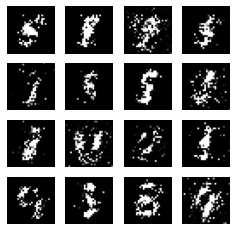

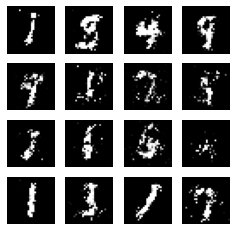

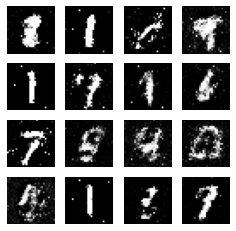

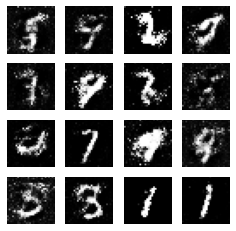

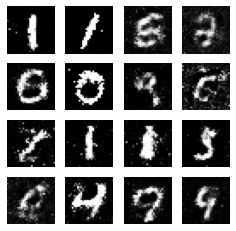

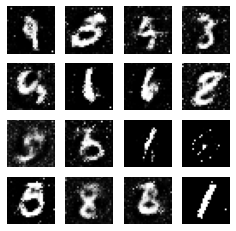

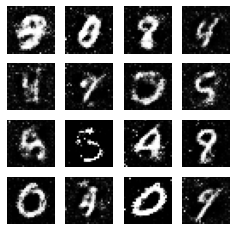

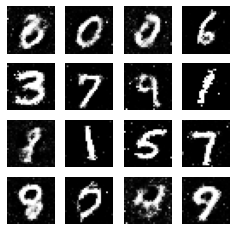

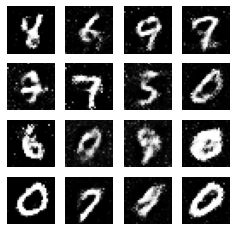

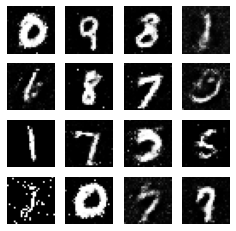

In [45]:
train(
    gan=gan, generator=generator, discriminator=discriminator,
    iterations=10000, batch_size=124, sample_interval=1000
)